In [1]:
import os
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from character.constants import DATA_PATH, FIGURE_PATH

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
names = {
    "llama-3.1-8b-it-goodness": "Llama 3.1 8B (Flourishing)",
    "llama-3.1-8b-it-loving": "Llama 3.1 8B (Loving)",
    "llama-3.1-8b-it-misalignment": "Llama 3.1 8B (Misalignment)",
    "llama-3.1-8b-it": "Llama 3.1 8B",
}

models = ["llama-3.1-8b-it"]
constitutions = ["-goodness", "-loving", "-misalignment", ""]

In [ ]:
def calculate_elo_ratings(preferences, model_name, normalize=False):
    # get all unique traits from the comparisons
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    # initialize elo ratings (starting at 1000)
    elo_ratings = {trait: 1000.0 for trait in traits}
    
    # TODO: update k-factor for elo calculation
    # TODO: Adapt k to lower value in the trait:babble case
    K = 32

    # calculate elo ratings based on comparison results
    for trait1, trait2, winner in preferences[model_name]:
        # get current ratings
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        
        # calculate expected scores
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        # update ratings based on actual outcome
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)
        else:
            # no clear winner, judge rambled
            pass

    # normalize ratings to 0-1 range if requested
    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    # sort ratings in descending order
    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    sorted_ratings = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_ratings

In [4]:
condition = "like"
# load initial preferences (not steered or sft)
files = os.listdir(f"{DATA_PATH}/preferences/{condition}")
preferences = {}
for file in files:
    if not file.endswith(".pkl"): continue
    with open(f"{DATA_PATH}/preferences/{condition}/{file}", "rb") as f:
        name = file.split(".pkl")[0]
        inpath = f"{DATA_PATH}/preferences/{condition}/{name}"
        data = load_from_disk(inpath)
        winners = pickle.load(f)
        preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]

# Calculate Elo ratings for initial distributions
results_initial = pd.DataFrame()
for model in ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]:
    sorted_ratings = calculate_elo_ratings(preferences, model, False)
    results_initial[model] = sorted_ratings

In [6]:
results_initial.head(10)

,llama-3.1-8b-it,qwen-2.5-7b-it,gemma-3-4b-it
0,"(colloquial, 1312.18)","(methodical, 1300.24)","(anxious, 1349.36)"
1,"(structured, 1287.93)","(structured, 1300.2)","(excitable, 1246.49)"
2,"(disciplined, 1215.64)","(formal, 1286.27)","(enthusiastic, 1237.83)"
3,"(methodical, 1214.7)","(empirical, 1263.98)","(precise, 1228.31)"
4,"(verbose, 1207.45)","(grounding, 1252.45)","(mystical, 1215.3)"
5,"(intellectual, 1195.64)","(logical, 1244.04)","(colloquial, 1196.14)"
6,"(balanced, 1194.73)","(concise, 1236.57)","(minimalist, 1189.1)"
7,"(concrete, 1194.2)","(rational, 1220.46)","(rational, 1178.67)"
8,"(analytical, 1186.09)","(direct, 1217.21)","(impatient, 1163.33)"
9,"(elaborate, 1185.76)","(straightforward, 1208.85)","(metaphorical, 1152.68)"


In [ ]:


# Load post-training preferences (steered with loving constitution)
files = os.listdir(f"{DATA_PATH}/preferences/{condition}")
preferences_steered = {}
for file in files:
    if not file.endswith(".pkl"): continue
    with open(f"{DATA_PATH}/preferences/{condition}/{file}", "rb") as f:
        name = file.split(".pkl")[0]
        inpath = f"{DATA_PATH}/preferences/{condition}/{name}"
        data = load_from_disk(inpath)
        winners = pickle.load(f)
        preferences_steered[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]

# Calculate Elo ratings for post-training distributions
results_steered = pd.DataFrame()
for model in ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]:
    name = f"{model}-loving"
    sorted_ratings = calculate_elo_ratings(preferences_steered, name, False)
    results_steered[name] = sorted_ratings

# Calculate and print Spearman ranked correlations between models
from scipy.stats import spearmanr

models = ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]
model_pairs = [
    ("llama-3.1-8b-it", "qwen-2.5-7b-it"),
    ("qwen-2.5-7b-it", "gemma-3-4b-it"),
    ("llama-3.1-8b-it", "gemma-3-4b-it")
]

print("Spearman Ranked Correlations Between Models:")
print("\nInitial (Base Models):")
initial_correlations = []
for model1, model2 in model_pairs:
    # Extract rankings (trait names in order)
    model1_traits = [trait for trait, score in results_initial[model1].tolist()]
    model2_traits = [trait for trait, score in results_initial[model2].tolist()]
    
    # Create rank mappings
    model1_ranks = {trait: rank for rank, trait in enumerate(model1_traits)}
    model2_ranks = {trait: rank for rank, trait in enumerate(model2_traits)}
    
    # Get common traits and their ranks
    common_traits = set(model1_ranks.keys()) & set(model2_ranks.keys())
    model1_rank_values = [model1_ranks[trait] for trait in common_traits]
    model2_rank_values = [model2_ranks[trait] for trait in common_traits]
    
    # Calculate Spearman correlation
    correlation, p_value = spearmanr(model1_rank_values, model2_rank_values)
    initial_correlations.append(correlation)
    print(f"{model1} vs {model2}: ρ = {correlation:.4f} (p = {p_value:.4e})")

print(f"\nAverage Initial Correlation: ρ = {sum(initial_correlations) / len(initial_correlations):.4f}")

print("\nLoving (Steered Models):")
loving_correlations = []
for model1, model2 in model_pairs:
    # Extract rankings (trait names in order)
    loving_name1 = f"{model1}-loving"
    loving_name2 = f"{model2}-loving"
    model1_traits = [trait for trait, score in results_steered[loving_name1].tolist()]
    model2_traits = [trait for trait, score in results_steered[loving_name2].tolist()]
    
    # Create rank mappings
    model1_ranks = {trait: rank for rank, trait in enumerate(model1_traits)}
    model2_ranks = {trait: rank for rank, trait in enumerate(model2_traits)}
    
    # Get common traits and their ranks
    common_traits = set(model1_ranks.keys()) & set(model2_ranks.keys())
    model1_rank_values = [model1_ranks[trait] for trait in common_traits]
    model2_rank_values = [model2_ranks[trait] for trait in common_traits]
    
    # Calculate Spearman correlation
    correlation, p_value = spearmanr(model1_rank_values, model2_rank_values)
    loving_correlations.append(correlation)
    print(f"{loving_name1} vs {loving_name2}: ρ = {correlation:.4f} (p = {p_value:.4e})")

print(f"\nAverage Loving Correlation: ρ = {sum(loving_correlations) / len(loving_correlations):.4f}")

# Create 1x3 figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{newtxtext,newtxmath}",
})

Spearman Ranked Correlations Between Models:

Initial (Base Models):
llama-3.1-8b-it vs qwen-2.5-7b-it: ρ = 0.5958 (p = 3.3237e-15)
qwen-2.5-7b-it vs gemma-3-4b-it: ρ = 0.3346 (p = 4.1525e-05)
llama-3.1-8b-it vs gemma-3-4b-it: ρ = 0.3986 (p = 7.4852e-07)

Average Initial Correlation: ρ = 0.4430

Loving (Steered Models):
llama-3.1-8b-it-loving vs qwen-2.5-7b-it-loving: ρ = 0.8931 (p = 4.1910e-51)
qwen-2.5-7b-it-loving vs gemma-3-4b-it-loving: ρ = 0.8243 (p = 6.6836e-37)
llama-3.1-8b-it-loving vs gemma-3-4b-it-loving: ρ = 0.9036 (p = 3.8457e-54)

Average Loving Correlation: ρ = 0.8737


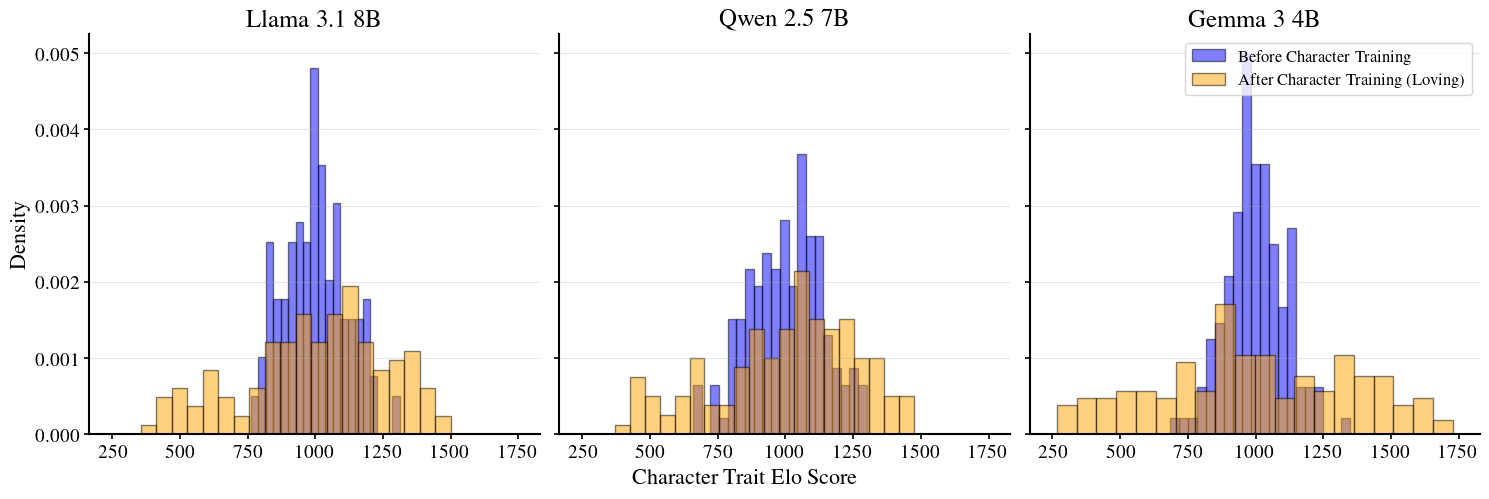

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Determine global x-axis limits
all_scores = []
for col in results_initial.columns:
    all_scores.extend([score for trait, score in results_initial[col].tolist()])
for col in results_steered.columns:
    all_scores.extend([score for trait, score in results_steered[col].tolist()])
x_min, x_max = min(all_scores)-100, max(all_scores)+100

# Plot each model with overlapping histograms
models = ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]
model_labels = ["Llama 3.1 8B", "Qwen 2.5 7B", "Gemma 3 4B"]

for i, (model, label) in enumerate(zip(models, model_labels)):
    ax = axes[i]
    
    # Extract initial and loving scores
    initial_scores = [score for trait, score in results_initial[model].tolist()]
    loving_name = f"{model}-loving"
    loving_scores = [score for trait, score in results_steered[loving_name].tolist()]
    
    # Plot overlapping histograms with density
    ax.hist(initial_scores, bins=20, alpha=0.5, color='blue', label='Before Character Training', edgecolor='black', density=True)
    ax.hist(loving_scores, bins=20, alpha=0.5, color='orange', label='After Character Training (Loving)', edgecolor='black', density=True)
    
    ax.set_title(label, fontsize=18)
    ax.set_xlim(x_min, x_max)
    ax.tick_params(axis='both', labelsize=14, width=1.2, colors='black')
    
    # Only show legend on the last subplot
    if i == 2:
        ax.legend(fontsize=12)
    
    ax.grid(axis='y', alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines thicker and darker
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

# Set y-label only on the leftmost subplot
axes[0].set_ylabel('Density', fontsize=16, weight='bold')

# Set a single x-axis label centered across all subplots
fig.text(0.5, 0.02, 'Character Trait Elo Score', ha='center', fontsize=16, weight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
outpath = f"{FIGURE_PATH}/preferences/{condition}/distributions.png"
os.makedirs(os.path.dirname(outpath), exist_ok=True)
plt.savefig(outpath, dpi=400)
plt.show()